### Monitoring wetland dynamics and its impact on malaria in the Zambesi delta, Mozambique

#### Context
What are wetlands?, why important?  
Why monitor?  
Relationship to malaria? Why it matters?  

### Method Description
1. Tasselled-Cap Wetnees (TCW) from surface reflectance
2. Fractional Cover
3. Masking using WOfS and TCW
4. Stacking and classifying the dominant land type
5. Comparison to malaria incidence rate 

#### 1. Tasseled-Cap Wetness(TCW) computaion from surface reflectance
TCW is one of the Tasseled-Cap Transform (TCT) indices, which uses a linear combination of Landsat bands to detect moisture content in soil and vegetation. The equations vary by Landsat sensor:

Landsat 5 & 7 (TM) Coefficients  
TCW=0.1509B1+0.1973B2+0.3279B3+0.3406B4−0.7112B5−0.4572B7  
Landsat 7 (ETM+) Coefficients  
TCW=0.2626B1+0.2141B2+0.0926B3+0.0656B4−0.7629B5−0.5388B7  
Landsat 8 & 9 (OLI) Coefficients  
TCW=0.1511𝐵2+0.1973𝐵3+0.3283𝐵4+0.3407𝐵5−0.7117𝐵6−0.4559𝐵7  
TCW=0.1511B2+0.1973B3+0.3283B4+0.3407B5−0.7117B6−0.4559B7  

B1, B2, etc., are Landsat bands (Surface Reflectance)

TCW is sensitive to water content in soil and vegetation

Higher TCW means more moisture, lower TCW means drier surfaces

In [1]:
import datacube
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from skimage import exposure
from shapely.geometry import Polygon

from deafrica_tools.datahandling import load_ard, mostcommon_crs, wofs_fuser
from deafrica_tools.plotting import rgb, display_map, plot_wofs
from datacube.utils import masking, geometry
from datacube.utils.geometry import CRS
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import HiddenPrints
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.classification import HiddenPrints

In [2]:
#connect to datacube
dc = datacube.Datacube(app="Landsat_Surface_Reflectance")

In [3]:
# List Landsat products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    'sr').fillna(
        False)][display_columns].set_index('name')

,description
name,
dem_srtm,1 second elevation model
dem_srtm_deriv,1 second elevation model derivatives
ls5_sr,USGS Landsat 5 Collection 2 Level-2 Surface Re...
ls7_sr,USGS Landsat 7 Collection 2 Level-2 Surface Re...
ls8_sr,USGS Landsat 8 Collection 2 Level-2 Surface Re...
ls9_sr,USGS Landsat 9 Collection 2 Level-2 Surface Re...


In [4]:
dc_measurements = dc.list_measurements()
# Display available measurements for Landsat 8
landsat_collections = ["ls8_sr"] 
for collection in landsat_collections:
    collection in dc_measurements.index
    print(f"Measurements for {collection}:")
    display(dc_measurements.loc[collection])

Measurements for ls8_sr:


,name,dtype,units,nodata,aliases,flags_definition,add_offset,scale_factor
measurement,,,,,,,,
SR_B1,SR_B1,uint16,1,0.0,"[band_1, coastal_aerosol]",NaN,NaN,NaN
SR_B2,SR_B2,uint16,1,0.0,"[band_2, blue]",NaN,NaN,NaN
SR_B3,SR_B3,uint16,1,0.0,"[band_3, green]",NaN,NaN,NaN
SR_B4,SR_B4,uint16,1,0.0,"[band_4, red]",NaN,NaN,NaN
SR_B5,SR_B5,uint16,1,0.0,"[band_5, nir]",NaN,NaN,NaN
SR_B6,SR_B6,uint16,1,0.0,"[band_6, swir_1]",NaN,NaN,NaN
SR_B7,SR_B7,uint16,1,0.0,"[band_7, swir_2]",NaN,NaN,NaN
QA_PIXEL,QA_PIXEL,uint16,bit_index,1.0,"[pq, pixel_quality]","{'snow': {'bits': 5, 'values': {'0': 'not_high...",NaN,NaN
QA_RADSAT,QA_RADSAT,uint16,bit_index,0.0,"[radsat, radiometric_saturation]","{'nir_saturation': {'bits': 4, 'values': {'0':...",NaN,NaN


In [5]:
# Bounding box for Mopeia in Zambezi delta Mozambique
lat, lon = -17.97757, 35.7130
buffer = 0.177

# Add lat, lon, buffer together to get bounding box
x = (lon - buffer, lon + buffer)
y = (lat - buffer, lat + buffer)

print(x, y)

# View the location 
display_map(x=x, y=y)

(35.536, 35.89) (-18.15457, -17.80057)


In [6]:
# Define the function to create a query
def create_query(location, year):
    return {
        'x': location[0],  # location is the Geometry object
        'y': location[1],
        'time': (f"{year}-01-01", f"{year}-12-31"),  # Time range format (YYYY-MM-DD)
    }

# Define the years to query
years = [2017, 2020, 2023]
location= (x,y)

In [7]:
# Load ARD Landsat data for the specified time range (2013-2022) every 3rd year
# Initialize lists to store datasets for each product
ds_landsat_list = []

# Load products for each year (one by one, each product separately)
for year in years:
    print(f"Processing data for {year}...")
    
    # Define the query for the current year
    query = create_query(location, year)
    
    ds_landsat = load_ard(
        dc=dc,
        products=["ls8_sr"], 
        output_crs="epsg:32636",
        min_gooddata=0.85,
        mask_filters=(["opening", 3], ["dilation", 3]),
        measurements=["red", "green", "blue", "nir", "swir_1", "swir_2"],
        dask_chunks={'time': -1, 'x': 250, 'y': 250},  # Adjust chunking as needed
        group_by="solar_day",
        resolution=(-30, 30),
        **query
    )
    
    # Append the dataset to the list
    ds_landsat_list.append(ds_landsat)

# Concatenate along the 'time' dimension
ds_ls = xr.concat(ds_landsat_list, dim='time')

# Sort by time just in case
ds_ls = ds_ls.sortby('time')

print(ds_ls)


Processing data for 2017...
Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr


/opt/venv/lib/python3.12/site-packages/deafrica_tools/datahandling.py:244: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Counting good quality pixels for each time step
Filtering to 13 out of 42 time steps with at least 85.0% good quality pixels
Applying morphological filters to pq mask (['opening', 3], ['dilation', 3])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 13 time steps as a dask array
Processing data for 2020...
Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 17 out of 43 time steps with at least 85.0% good quality pixels
Applying morphological filters to pq mask (['opening', 3], ['dilation', 3])
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 17 time steps as a dask array
Processing data for 2023...
Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Counting good quality pixels for each time step
Filtering to 22 out of 46 time steps with at least 85.0% good quality pixels
Applying morphological filters to pq mask (['opening'

In [ ]:
# Visual sanity check
first_timestep = ds_ls.swir_1.isel(time=1)

print(first_timestep)
first_timestep.plot(cmap='Blues_r')

<xarray.DataArray 'swir_1' (y: 1326, x: 1270)> Size: 7MB
dask.array<getitem, shape=(1326, 1270), dtype=float32, chunksize=(250, 250), chunktype=numpy.ndarray>
Coordinates:
    time         datetime64[ns] 8B 2017-02-13T07:35:09.497636
  * y            (y) float64 11kB -1.97e+06 -1.97e+06 ... -2.01e+06 -2.01e+06
  * x            (x) float64 10kB 7.683e+05 7.683e+05 ... 8.064e+05 8.064e+05
    spatial_ref  int32 4B 32636
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref


In [9]:
verbose = True
resample_frequency = '1M'
TCW_threshold = -0.035 #The tasseled cap wetness threshold, beyond which a pixel will be considered 'wet'. Defaults to -0.035

# Create the Polygon representing the bounding box (Shapely format)
bbox_coords = [(x[0], y[0]), (x[0], y[1]), (x[1], y[1]), (x[1], y[0]), (x[0], y[0])]
bbox = Polygon(bbox_coords)

# Create the GeoDataFrame using GeoPandas
gdf = gpd.GeoDataFrame({"col1": ["name"]}, geometry=[bbox], crs="EPSG:32636")

# Check the GeoDataFrame (gdf)
print(gdf)

# # If gdf is of type datacube.utils.geometry._base.Geometry, convert it to GeoDataFrame
# if isinstance(gdf, geometry._base.Geometry):
#     gdf = gpd.GeoDataFrame({"col1": ["name"], "geometry": [gdf.geom]}, crs=gdf.crs)

# # Convert the GeoDataFrame to a datacube Geometry object
# geom = geometry.Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)

# create polygon mask
mask = xr_rasterize(gdf.iloc[[0]], ds_ls)
ds_ls = ds_ls.where(mask)

# calculate tasselled cap wetness within masked AOI

if verbose:
    print("calculating tasseled cap wetness index ")

with HiddenPrints():  # suppres the prints from this func
    tcw = calculate_indices(
        ds_ls, index=["TCW"], normalise=False, satellite_mission="ls", drop=True
    )

if resample_frequency is not None:
    if verbose:
        print("Resampling TCW to " + resample_frequency)
    tcw = tcw.resample(time=resample_frequency).max()

tcw = tcw.TCW >= TCW_threshold
tcw = tcw.where(mask, 0)
tcw = tcw.persist()

   col1                                           geometry
0  name  POLYGON ((35.536 -18.155, 35.536 -17.801, 35.8...
calculating tasseled cap wetness index 
Resampling TCW to 1M


In [10]:
print(tcw)

<xarray.DataArray 'TCW' (time: 84, y: 1326, x: 1270)> Size: 1GB
dask.array<where, shape=(84, 1326, 1270), dtype=int64, chunksize=(10, 250, 250), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 11kB -1.97e+06 -1.97e+06 ... -2.01e+06 -2.01e+06
  * x            (x) float64 10kB 7.683e+05 7.683e+05 ... 8.064e+05 8.064e+05
    spatial_ref  int32 4B 32636
  * time         (time) datetime64[ns] 672B 2017-01-31 2017-02-28 ... 2023-12-31


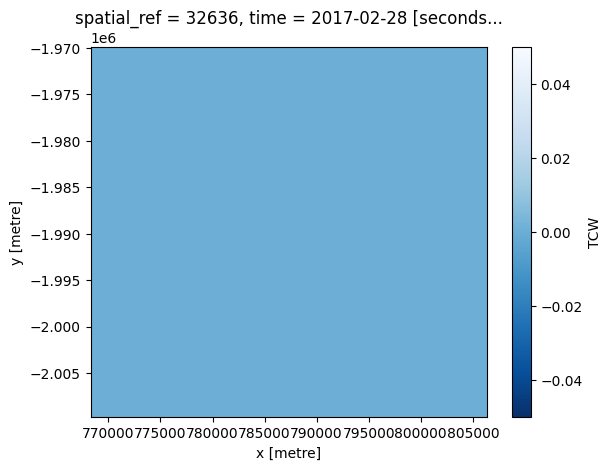

In [11]:
tcw.isel(time=1).plot(cmap='Blues_r')  # Plot time step

#### 2. WOfS 

In [ ]:
dc_wofs = datacube.Datacube(app="Intro_WOfS")

In [ ]:
#load the wofs features
# Initialize lists to store datasets for each product
ds_wofs_list = []

# Load products for each year (one by one, each product separately)
for year in years:
    print(f"Processing data for {year}...")
    
    # Define query for this year
    query = create_query(location, year)
    
    ds_wofsls = dc_wofs.load(
        product="wofs_ls",
        like=ds_landsat,
        fuse_func=wofs_fuser,
        dask_chunks={}, #{'time':-1, 'x':250, 'y':250}
        collection_category="T1",
    )
    ds_wofs_list.append(ds_wofsls)  # Append WOfS data to the list

# Concatenate along the 'time' dimension
ds_wofls = xr.concat(ds_wofs_list, dim='time')

# Sort by time just in case
ds_wofls = ds_wofls.sortby('time')

print(ds_wofls)


In [ ]:
# maksing the wet and dry areas
verbose= True
resample_frequency= "1M"

# boolean of wet/dry
wofls_wet = masking.make_mask(ds_wofls.water, wet=True)

if resample_frequency is not None:
    if verbose:
        print("Resampling WOfS to " + resample_frequency)
    wofls_wet = wofls_wet.resample(time=resample_frequency).max()

# mask sure wofs matches other datasets
wofls_wet = wofls_wet.where(wofls_wet.time == tcw.time)

# apply the polygon mask
wofls_wet = wofls_wet.where(mask)

#### 3. Fractional Cover (FC)

In [ ]:
# load fractional cover
    fc_ds = dc.load(
        product="fc_ls",
        time=time,
        dask_chunks=dask_chunks,
        like=ds_ls,
        measurements=["pv", "npv", "bs"],
        collection_category="T1",
    )

#### 4. Stacking and classifying land type

#### 5. compare statistics: water inundation vs malaria incidence rate